In [1]:
# connect to my drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd drive/MyDrive/gpt2_vs_bert_rc_squadv2/

/content/drive/MyDrive/gpt2_vs_bert_rc_squadv2


In [3]:
!pip install -U datasets
!pip install evaluate

# Fine-tune and testing

In [ ]:
!python -m gpt2_vs_bert_rc_squadv2.preprocessing

loading squadv2 mini...
downloading tokenizer ...
tokenizer_config.json: 100% 49.0/49.0 [00:00<00:00, 364kB/s]
config.json: 100% 762/762 [00:00<00:00, 6.22MB/s]
vocab.txt: 100% 213k/213k [00:00<00:00, 10.2MB/s]
tokenizer.json: 100% 436k/436k [00:00<00:00, 3.09MB/s]
saving tokenizer ...
preprocessing train set...
tokenizing...
fine answer in each feauture...
preprocessing dev set...
tokenizing...
fine answer in each feauture...
processing...
saving to ./gpt2_vs_bert_rc_squadv2/dataset/preprocessed_dataset_bert-large-cased...
./gpt2_vs_bert_rc_squadv2/dataset/preprocessed_dataset_bert-large-cased/train.pkl
./gpt2_vs_bert_rc_squadv2/dataset/preprocessed_dataset_bert-large-cased/dev.pkl
train set completed
dev set completed


In [ ]:
!python -m gpt2_vs_bert_rc_squadv2.fine_tuning

2025-05-25 22:33:29.195977: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-25 22:33:29.213739: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748212409.235680    3790 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748212409.242371    3790 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-25 22:33:29.264255: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [ ]:
!python -m gpt2_vs_bert_rc_squadv2.inferencing

2025-05-26 01:42:26.914704: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-26 01:42:26.931974: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748223746.953203   53150 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748223746.959702   53150 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-26 01:42:26.980989: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# Demo

In [4]:
from datasets import Dataset
from gpt2_vs_bert_rc_squadv2.inferencing import QaModel

data = {
    "id": ["1", "2", "3"],
    "context": [
        "The sky is blue.",
        "Water boils at 100 degrees Celsius.",
        "Python is a programming language.",
    ],
    "question": [
        "What color is the sky?",
        "At what temperature does water boil?",
        "What is Python?",
    ],
}
samples = Dataset.from_dict(data)
model = QaModel()
result = model.pipeline(samples)
print(result)

Loading model...
loaded model completed
tokenizing...
processing...


inferencing...: 100%|██████████| 1/1 [02:03<00:00, 123.97s/it]


clear dataloader...
[{'id': '1', 'prediction_text': ' blue.', 'no_answer_probability': 0.0013670568919744162}, {'id': '2', 'prediction_text': ' 100 degrees Celsius.', 'no_answer_probability': 8.656095398301491e-05}, {'id': '3', 'prediction_text': ' a programming language.', 'no_answer_probability': 5.825661407120966e-06}]


# Evaluation

In [ ]:
cd drive/MyDrive/gpt2_vs_bert_rc_squadv2/gpt2_vs_bert_rc_squadv2/

/content/drive/MyDrive/gpt2_vs_bert_rc_squadv2/gpt2_vs_bert_rc_squadv2


In [ ]:
import re
import matplotlib.pyplot as plt
import os
import json
from collections import defaultdict
import numpy as np

In [ ]:

ptrain, pdev = re.compile(r'e: (\d+), b: (\d+), l: (\d+.\d+)'), re.compile(r'e: (\d+), b: (\d+), val_l: (\d+.\d+)')
peval = re.compile(r"epoch (\d), metric: \{'exact': (\d+.\d+), 'f1': (\d+.\d+), 'total': (\d+), 'HasAns_exact': (\d+.\d+), 'HasAns_f1': (\d+.\d+), 'HasAns_total': (\d+), 'NoAns_exact': (\d+.\d+), 'NoAns_f1': (\d+.\d+), 'NoAns_total': (\d+), 'best_exact': (\d+.\d+), 'best_exact_thresh': (\d+.\d+), 'best_f1': (\d+.\d+), 'best_f1_thresh': (\d+.\d+)\}")

func = lambda : defaultdict(list)
model_cards = {'bert-base-cased': func(), 'bert-large-cased': func(), 'gpt2': func(), 'gpt2-medium': func()}

# read result
for key in model_cards.keys():
  with open(os.path.join(f'fine_tune_result_{key}', 'eval.txt'), 'r') as f1, \
  open(os.path.join(f'fine_tune_result_{key}', 'train_loss.txt'), 'r') as f2, \
  open(os.path.join(f'fine_tune_result_{key}', 'val_loss.txt'), 'r') as f3, \
  open(os.path.join(f'result_{key}', 'metric.json'), 'r') as f4:
    model_cards[key]['dev_eval'] += peval.findall(f1.read())
    model_cards[key]['train_loss'] += ptrain.findall(f2.read())
    model_cards[key]['dev_loss'] += pdev.findall(f3.read())
    model_cards[key]['test_eval'] = json.load(f4)

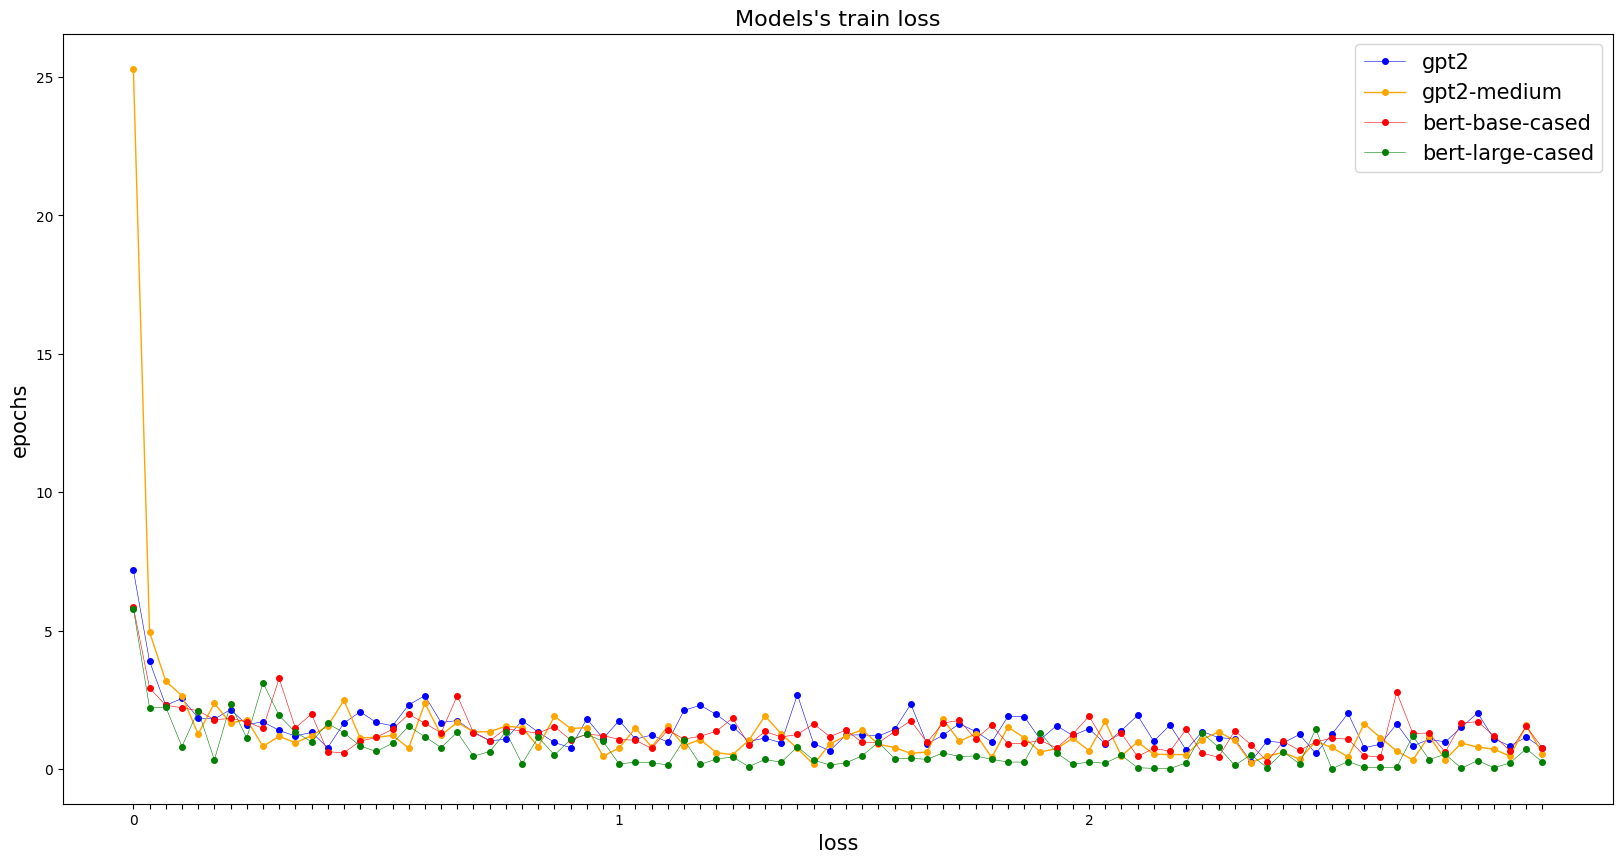

In [ ]:

loss='train_loss'
title="Models's train loss"
iter_=550
marker='o'
figsize=(20, 10)
lw=0.4

gpt2 = model_cards['gpt2'][loss]
gpt2_medium = model_cards['gpt2-medium'][loss]
bert_base = model_cards['bert-base-cased'][loss]
bert_large = model_cards['bert-large-cased'][loss]

x, labels = [], []
y_gpt2, y_gpt2_medium, y_bert_large, y_bert_base = [], [], [], []
iter = 0
curr_e = -1

for i in range(len(gpt2)):
  if i == iter:
    x += [i]

    y_gpt2 += [float(gpt2[i][2])]
    y_gpt2_medium += [float(gpt2_medium[i][2])]
    y_bert_base += [float(bert_base[i][2])]
    y_bert_large += [float(bert_large[i][2])]

    labels += [gpt2[i][0] if curr_e != int(gpt2[i][0]) else '']
    curr_e = int(gpt2[i][0])
    iter += iter_

plt.figure(figsize=figsize)
plt.plot(x, y_gpt2, color='b', marker=marker, linewidth=lw, markersize=4, label='gpt2')
plt.plot(x, y_gpt2_medium, color='orange', marker=marker, linewidth=1, markersize=4, label='gpt2-medium')
plt.plot(x, y_bert_base, color='r', marker=marker, linewidth=lw, markersize=4, label='bert-base-cased')
plt.plot(x, y_bert_large, color='g', marker=marker, linewidth=lw, markersize=4, label='bert-large-cased')

# Set custom tick positions and labels
plt.xticks(ticks=x, labels=labels)
plt.ylabel('epochs', fontsize=15)
plt.xlabel('loss', fontsize=15)
plt.title(title, fontsize=16)

plt.legend(fontsize=15)
plt.savefig('trainloss.png')
plt.show()


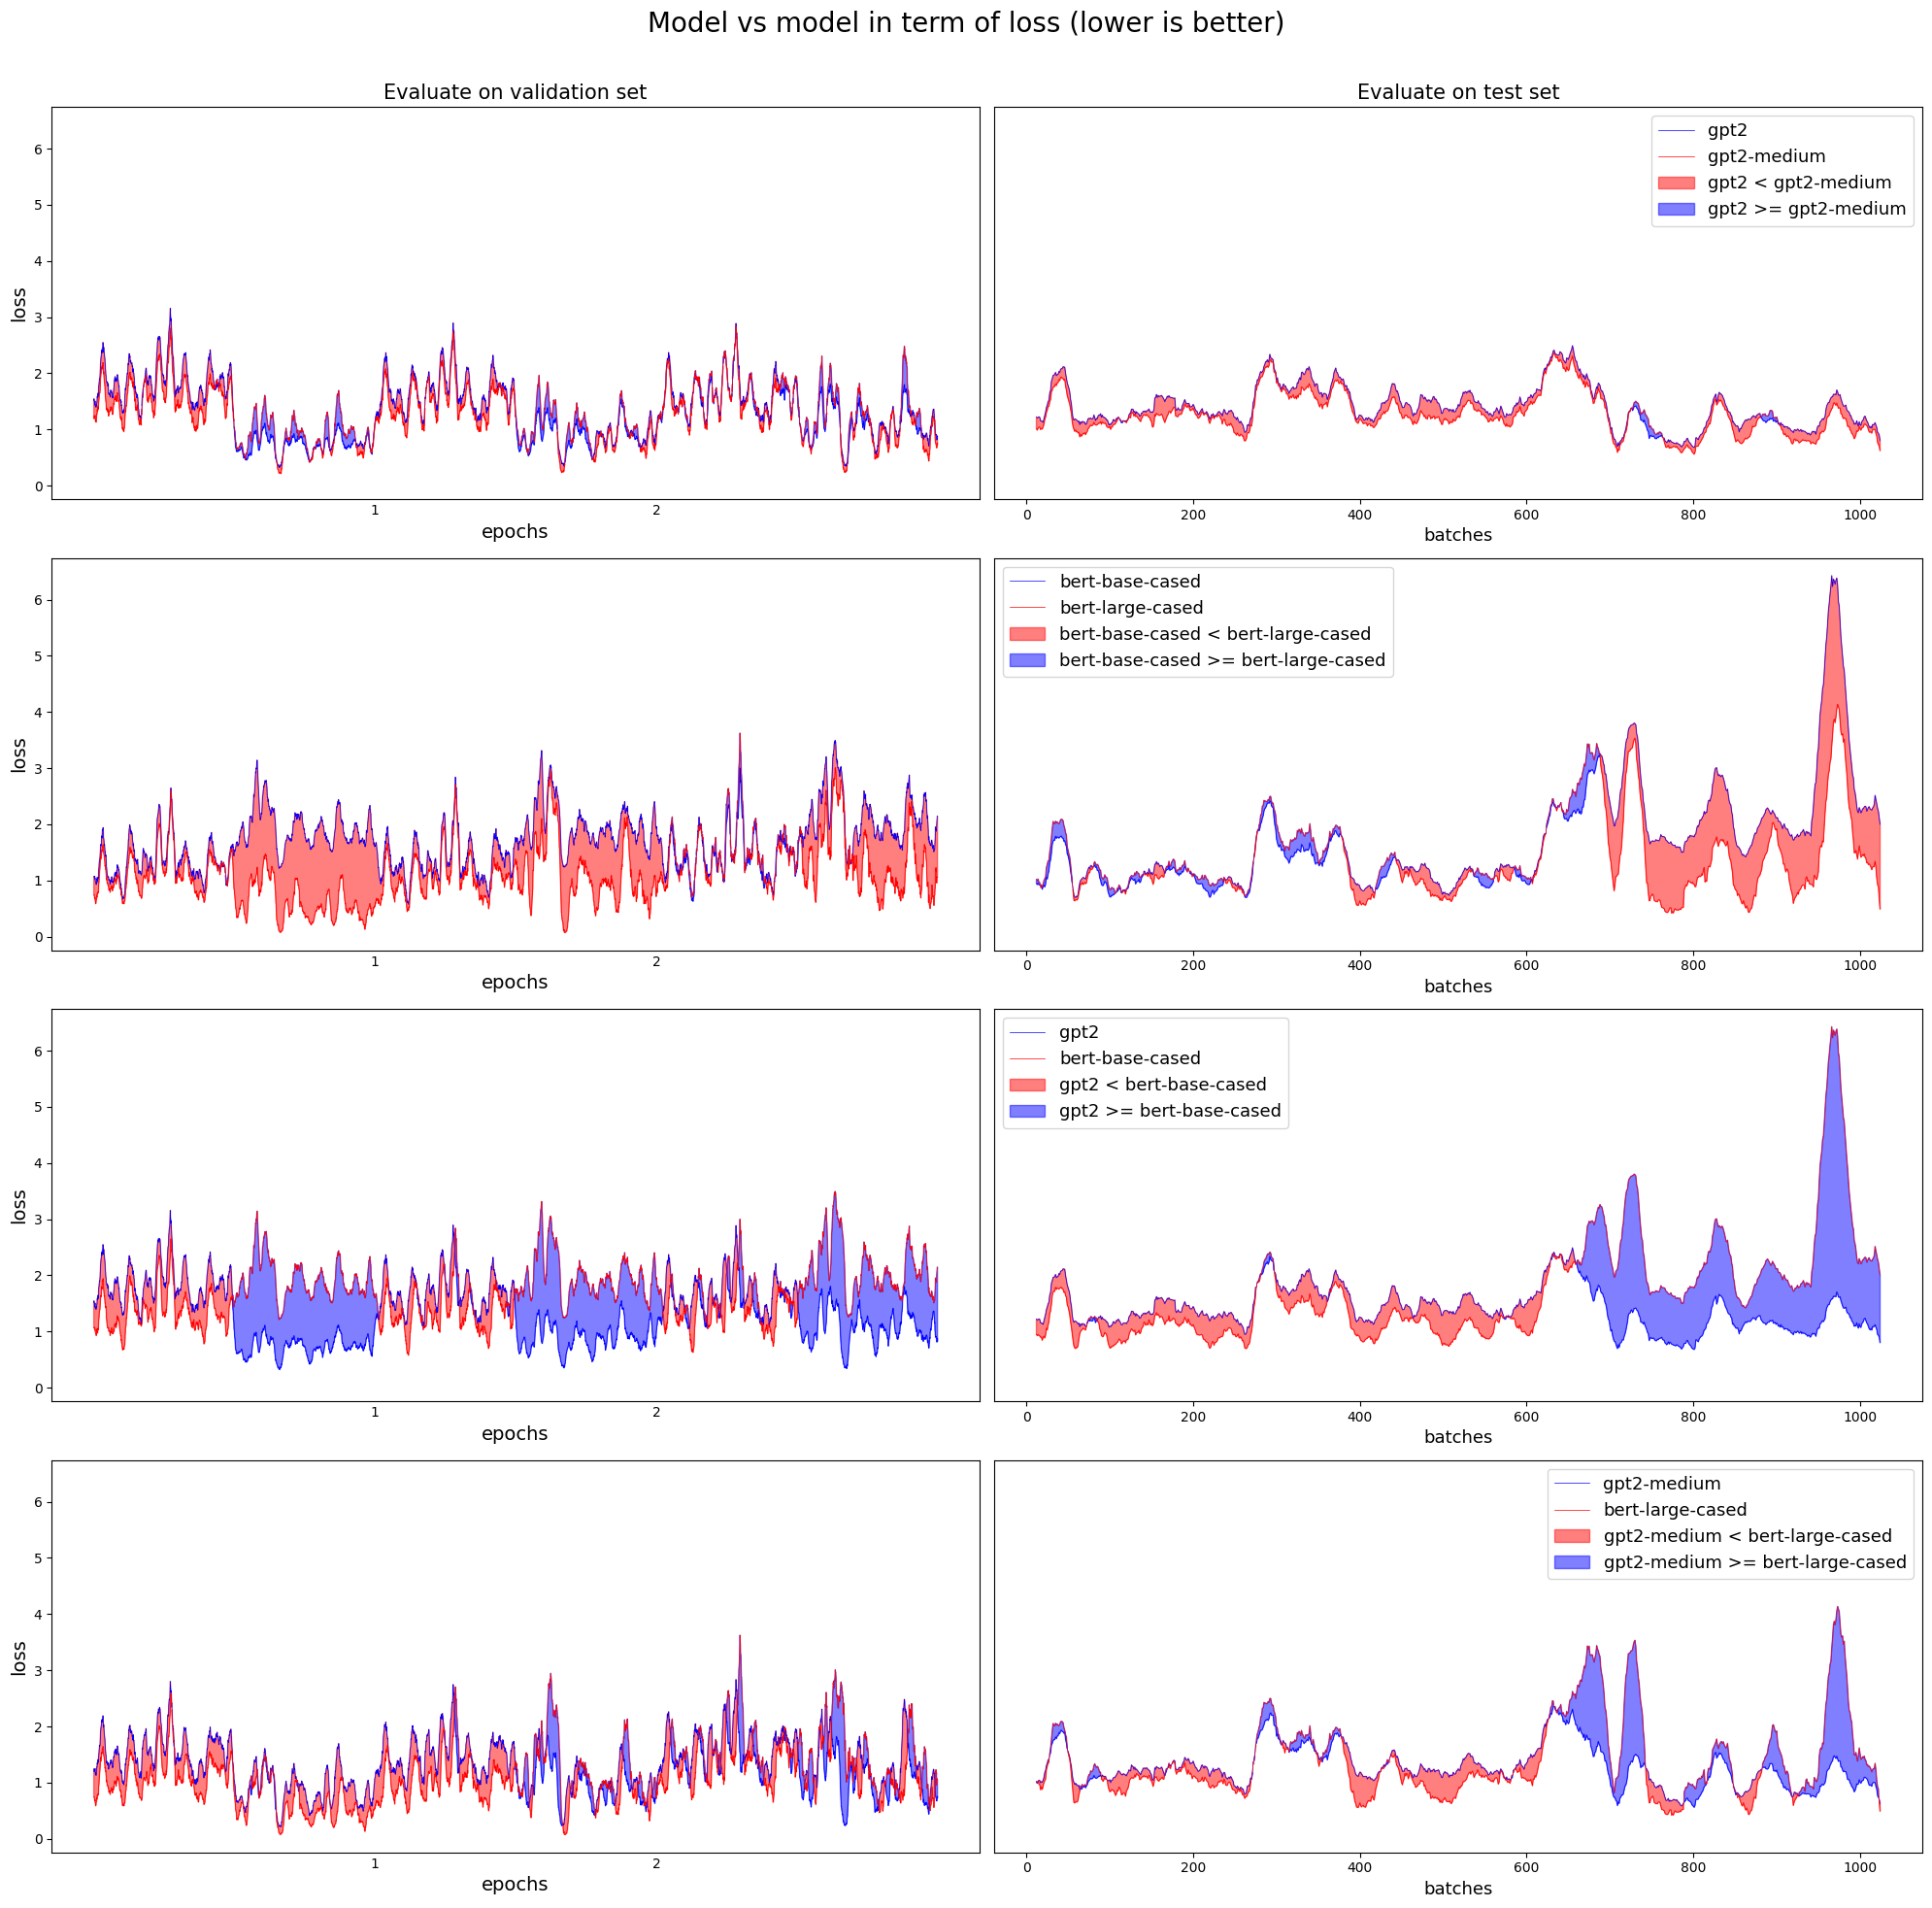

In [ ]:
gpt2 = model_cards['gpt2']['dev_loss']
gpt2_medium = model_cards['gpt2-medium']['dev_loss']
bert_base = model_cards['bert-base-cased']['dev_loss']
bert_large = model_cards['bert-large-cased']['dev_loss']

x, labels = list(range(len(gpt2))), []
y_gpt2, y_gpt2_medium, y_bert_large, y_bert_base = [], [], [], []
curr_e = -1

for i in x:
  y_gpt2 += [float(gpt2[i][2])]
  y_gpt2_medium += [float(gpt2_medium[i][2])]
  y_bert_base += [float(bert_base[i][2])]
  y_bert_large += [float(bert_large[i][2])]

  labels += [gpt2[i][0] if curr_e != int(gpt2[i][0]) else '']
  curr_e = int(gpt2[i][0])

# smooth out y
window = 25
def smooth_y(x_, *y):
  f_smooth = lambda x : np.convolve(x, np.ones(window)/window, mode='valid')

  x_ = x_[(window - 1)//2 : -(window//2)]
  return (x_, *(f_smooth(i) for i in y))

labels = labels[(window - 1)//2 : -(window//2)]

x, y_gpt2, y_gpt2_medium, y_bert_large, y_bert_base = smooth_y(x, y_gpt2, y_gpt2_medium, y_bert_large, y_bert_base)

a = 0.5
def set_tick(row, col, title, y1, y2, y1_l, y2_l):
  ax[row][col].fill_between(x, y1, y2, where=[a > b for a, b in zip(y1, y2)], color='r', alpha=a, label=f'{y1_l} < {y2_l}')
  ax[row][col].fill_between(x, y1, y2, where=[a <= b for a, b in zip(y1, y2)], color='b', alpha=a, label=f'{y1_l} >= {y2_l}')

  if row == 0 and col == 0:
    ax[row][col].set_title('Evaluate on validation set', fontsize=15)

  ax[row][col].set_xticks(ticks=x, labels=labels)
  ax[row][col].tick_params(axis='x', which='both', length=0)
  ax[row][col].set_xlabel('epochs', fontsize=14)
  ax[row][col].set_ylabel('loss', fontsize=14)

def set_tick_(row, col, title, y1, y2, y1_l, y2_l):
  ax[row][col].fill_between(x, y1, y2, where=[a > b for a, b in zip(y1, y2)], color='r', alpha=a, label=f'{y1_l} < {y2_l}')
  ax[row][col].fill_between(x, y1, y2, where=[a <= b for a, b in zip(y1, y2)], color='b', alpha=a, label=f'{y1_l} >= {y2_l}')

  if row == 0 and col == 1:
    ax[row][col].set_title('Evaluate on test set', fontsize=15)

  ax[row][col].set_xlabel('batches', fontsize=13)
  ax[row][col].tick_params(axis='y', which='both', length=0)
  ax[row][col].legend(fontsize=13)

def plot_(row, col, y_model1, y_model2, m1, m2, set_tick_f):
  ax[row][col].plot(x, y_model1, linewidth=0.5, color='b', label=m1)
  ax[row][col].plot(x, y_model2, linewidth=0.5, color='r', label=m2)
  set_tick_f(row, col, f'{m1} vs {m2}', y_model1, y_model2, m1, m2)

fig, ax = plt.subplots(4, 2, sharey=True, figsize=(20, 20))

plot_(0, 0, y_gpt2, y_gpt2_medium, 'gpt2', 'gpt2-medium', set_tick)
plot_(1, 0, y_bert_base, y_bert_large, 'bert-base-cased', 'bert-large-cased', set_tick)
plot_(2, 0, y_gpt2, y_bert_base, 'gpt2', 'bert-base-cased', set_tick)
plot_(3, 0, y_gpt2_medium, y_bert_large, 'gpt2-medium', 'bert-large-cased', set_tick)

# test
gpt2 = model_cards['gpt2']['test_eval']['loss']
gpt2_medium = model_cards['gpt2-medium']['test_eval']['loss']
bert_base = model_cards['bert-base-cased']['test_eval']['loss']
bert_large = model_cards['bert-large-cased']['test_eval']['loss']

x = list(range(len(gpt2)))
y_gpt2, y_gpt2_medium, y_bert_large, y_bert_base = [], [], [], []

for i in x:
  y_gpt2 += [float(gpt2[i]['l'])]
  y_gpt2_medium += [float(gpt2_medium[i]['l'])]
  y_bert_base += [float(bert_base[i]['l'])]
  y_bert_large += [float(bert_large[i]['l'])]

x, y_gpt2, y_gpt2_medium, y_bert_large, y_bert_base = smooth_y(x, y_gpt2, y_gpt2_medium, y_bert_large, y_bert_base)

plot_(0, 1, y_gpt2, y_gpt2_medium, 'gpt2', 'gpt2-medium', set_tick_)
plot_(1, 1, y_bert_base, y_bert_large, 'bert-base-cased', 'bert-large-cased', set_tick_)
plot_(2, 1, y_gpt2, y_bert_base, 'gpt2', 'bert-base-cased', set_tick_)
plot_(3, 1, y_gpt2_medium, y_bert_large, 'gpt2-medium', 'bert-large-cased', set_tick_)

fig.suptitle('Model vs model in term of loss (lower is better)', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.savefig('modelvsmodelloss.png')
plt.show()

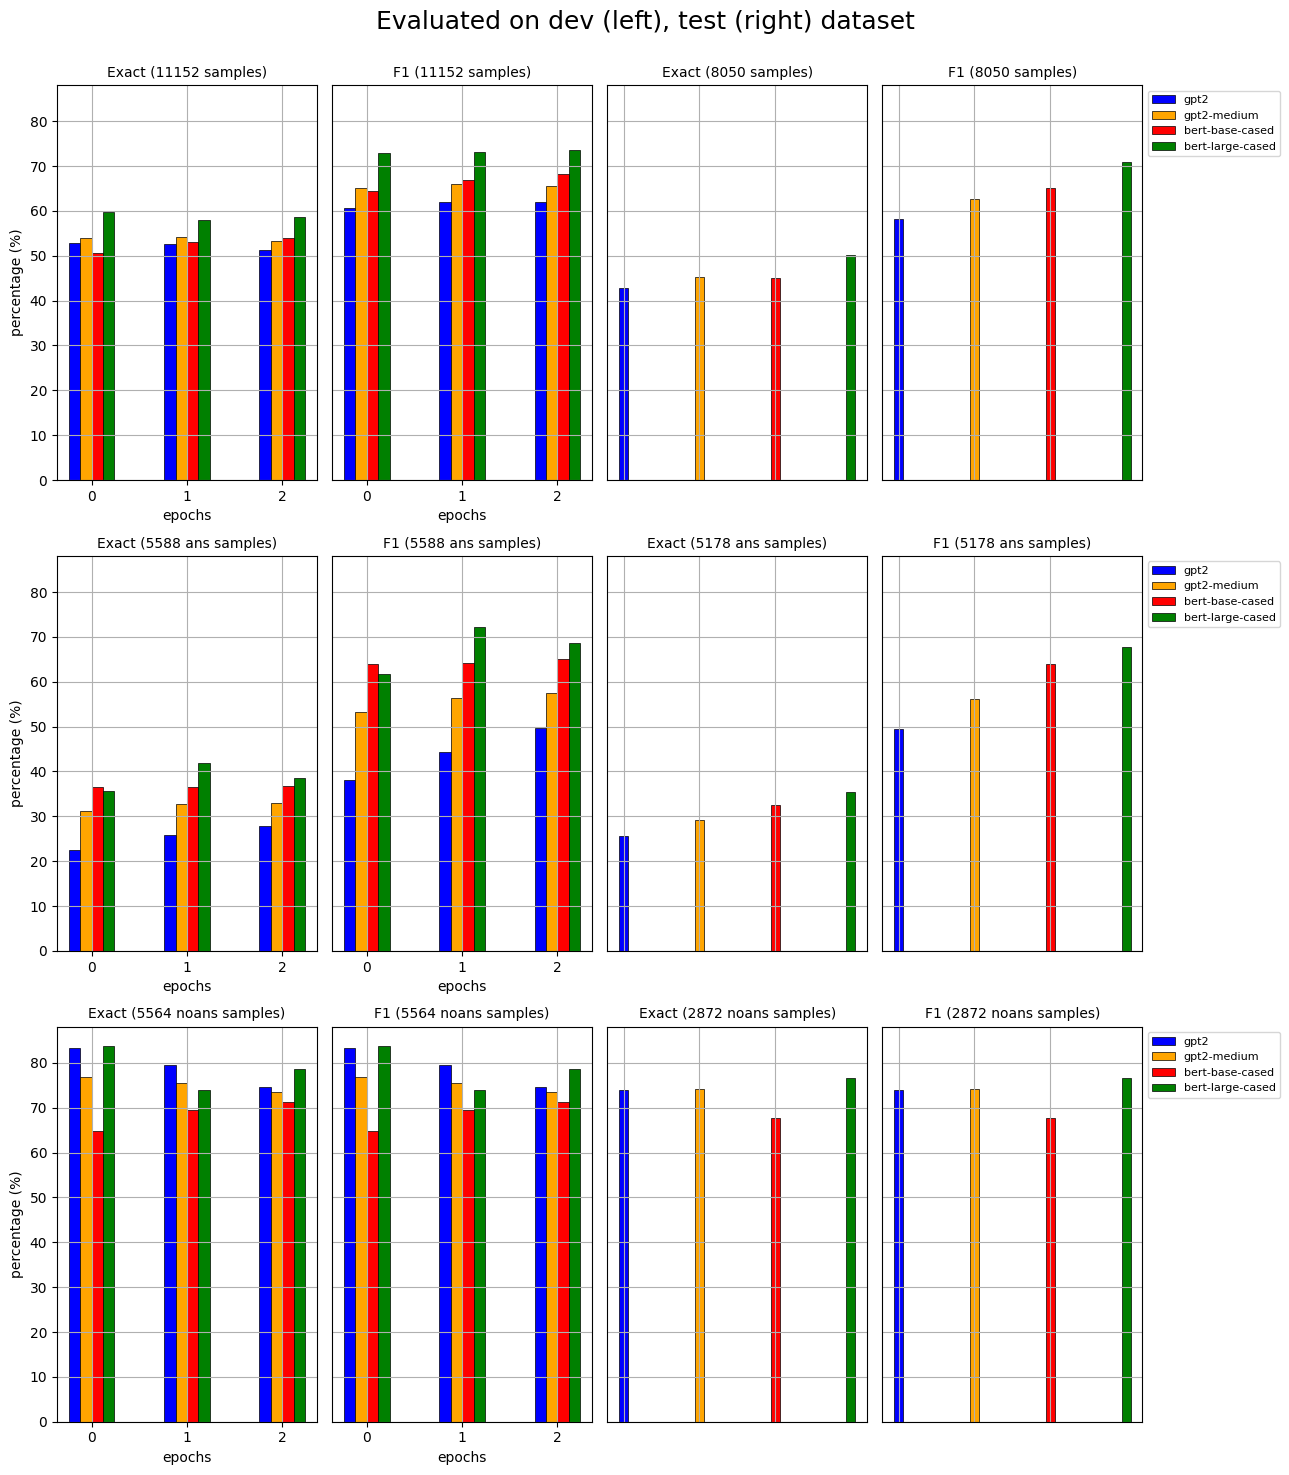

In [ ]:
gpt2 = model_cards['gpt2']['dev_eval']
gpt2_medium = model_cards['gpt2-medium']['dev_eval']
bert_base = model_cards['bert-base-cased']['dev_eval']
bert_large = model_cards['bert-large-cased']['dev_eval']

total_samples = gpt2[0][3]
has_ans_samples = gpt2[0][6]
no_ans_samples = gpt2[0][9]

x = np.array([0, 0.25, 0.5])
y_gpt2, y_gpt2_medium, y_bert_large, y_bert_base = [], [], [], []

for i in range(len(gpt2)):
  y_gpt2.append(gpt2[i])
  y_gpt2_medium.append(gpt2_medium[i])
  y_bert_base.append(bert_base[i])
  y_bert_large.append(bert_large[i])

def set_tick(r, c, title):
  ax[r][c].set_xticks(ticks=x, labels=[0, 1, 2])
  ax[r][c].set_title(title, fontsize=10)
  ax[r][c].grid(True)
  if c < 2:
    ax[r][c].set_xlabel('epochs', fontsize=10)
  if c == 3:
    ax[r][c].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)
  if c == 0:
    ax[r][c].set_ylabel('percentage (%)', fontsize=10)
  if c > 0:
    ax[r][c].tick_params(axis='both' if c >= 2 else 'y', which='both', length=0, labelbottom=False if c >= 2 else True)

fig, ax = plt.subplots(3, 4, sharey=True, figsize=(13, 15))
w, lw = 0.03, 0.5

def barplot(r, c, j, title):
  ax[r][c].bar(x - 1.5*w, [float(i[j]) for i in y_gpt2], width=w, linewidth=lw, edgecolor='black', color='b', label='gpt2')
  ax[r][c].bar(x - 0.5*w, [float(i[j]) for i in y_gpt2_medium], width=w, linewidth=lw, edgecolor='black', color='orange', label='gpt2-medium')
  ax[r][c].bar(x + 0.5*w, [float(i[j]) for i in y_bert_base], width=w, linewidth=lw, edgecolor='black', color='r', label='bert-base-cased')
  ax[r][c].bar(x + 1.5*w, [float(i[j]) for i in y_bert_large], width=w, linewidth=lw, edgecolor='black', color='g', label='bert-large-cased')
  set_tick(r, c, title)

barplot(0, 0, 1, f'Exact ({total_samples} samples)')
barplot(0, 1, 2, f'F1 ({total_samples} samples)')
barplot(1, 0, 4, f'Exact ({has_ans_samples} ans samples)')
barplot(1, 1, 5, f'F1 ({has_ans_samples} ans samples)')
barplot(2, 0, 7, f'Exact ({no_ans_samples} noans samples)')
barplot(2, 1, 8, f'F1 ({no_ans_samples} noans samples)')

# Test
gpt2 = model_cards['gpt2']['test_eval']['metric']
gpt2_medium = model_cards['gpt2-medium']['test_eval']['metric']
bert_base = model_cards['bert-base-cased']['test_eval']['metric']
bert_large = model_cards['bert-large-cased']['test_eval']['metric']

total_samples = gpt2['total']
has_ans_samples = gpt2['HasAns_total']
no_ans_samples = gpt2['NoAns_total']

def barplot_(r, c, key, title):
  ax[r][c].bar(0, gpt2[key], width=w, linewidth=lw, edgecolor='black', color='b', label='gpt2')
  ax[r][c].bar(0.25, gpt2_medium[key], width=w, linewidth=lw, edgecolor='black', color='orange', label='gpt2-medium')
  ax[r][c].bar(0.5, bert_base[key], width=w, linewidth=lw, edgecolor='black', color='r', label='bert-base-cased')
  ax[r][c].bar(0.75, bert_large[key], width=w, linewidth=lw, edgecolor='black', color='g', label='bert-large-cased')
  set_tick(r, c, title)

barplot_(0, 2, 'exact', f'Exact ({total_samples} samples)')
barplot_(0, 3, 'f1', f'F1 ({total_samples} samples)')
barplot_(1, 2, 'HasAns_exact', f'Exact ({has_ans_samples} ans samples)')
barplot_(1, 3, 'HasAns_f1', f'F1 ({has_ans_samples} ans samples)')
barplot_(2, 2, 'NoAns_exact', f'Exact ({no_ans_samples} noans samples)')
barplot_(2, 3, 'NoAns_f1', f'F1 ({no_ans_samples} noans samples)')

fig.suptitle('Evaluated on dev (left), test (right) dataset', fontsize=18)
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.savefig('evaluatedevtest.png')
plt.show()

In [ ]:
import collections
import os
import re
import string

def make_precision_recall_eval(scores, na_probs, num_true_pos, qid_to_has_ans):
  qid_list = sorted(na_probs, key=lambda k: na_probs[k])
  true_pos = 0.0
  cur_p = 1.0
  cur_r = 0.0
  precisions = [1.0]
  recalls = [0.0]

  for i, qid in enumerate(qid_list):
    if qid_to_has_ans[qid]:
        true_pos += scores[qid]
    cur_p = true_pos / float(i + 1)
    cur_r = true_pos / float(num_true_pos)

    if i == len(qid_list) - 1 or na_probs[qid] != na_probs[qid_list[i + 1]]:
        # i.e., if we can put a threshold after this point
        precisions.append(cur_p)
        recalls.append(cur_r)
  return precisions, recalls

def run_precision_recall_analysis(exact_raw, f1_raw, na_probs, qid_to_has_ans):
  num_true_pos = sum(1 for v in qid_to_has_ans.values() if v)
  if num_true_pos == 0:
    return
  pr_exact = make_precision_recall_eval(
      exact_raw,
      na_probs,
      num_true_pos,
      qid_to_has_ans,
  )
  pr_f1 = make_precision_recall_eval(
      f1_raw,
      na_probs,
      num_true_pos,
      qid_to_has_ans,
  )
  oracle_scores = {k: float(v) for k, v in qid_to_has_ans.items()}
  pr_oracle = make_precision_recall_eval(
      oracle_scores,
      na_probs,
      num_true_pos,
      qid_to_has_ans,
  )
  return pr_exact, pr_f1, pr_oracle

ARTICLES_REGEX = re.compile(r"\b(a|an|the)\b", re.UNICODE)
def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""

    def remove_articles(text):
        return ARTICLES_REGEX.sub(" ", text)

    def white_space_fix(text):
        return " ".join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))


def get_tokens(s):
    if not s:
        return []
    return normalize_answer(s).split()

def compute_exact(a_gold, a_pred):
    return int(normalize_answer(a_gold) == normalize_answer(a_pred))


def compute_f1(a_gold, a_pred):
    gold_toks = get_tokens(a_gold)
    pred_toks = get_tokens(a_pred)
    common = collections.Counter(gold_toks) & collections.Counter(pred_toks)
    num_same = sum(common.values())
    if len(gold_toks) == 0 or len(pred_toks) == 0:
        # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
        return int(gold_toks == pred_toks)
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(pred_toks)
    recall = 1.0 * num_same / len(gold_toks)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1


def get_raw_scores(dataset, preds):
    exact_scores = {}
    f1_scores = {}
    for article in dataset:
        for p in article["paragraphs"]:
            for qa in p["qas"]:
                qid = qa["id"]
                gold_answers = [t for t in qa["answers"]["text"] if normalize_answer(t)]
                if not gold_answers:
                    # For unanswerable questions, only correct answer is empty string
                    gold_answers = [""]
                if qid not in preds:
                    print(f"Missing prediction for {qid}")
                    continue
                a_pred = preds[qid]
                # Take max over all gold answers
                exact_scores[qid] = max(compute_exact(a, a_pred) for a in gold_answers)
                f1_scores[qid] = max(compute_f1(a, a_pred) for a in gold_answers)
    return exact_scores, f1_scores

def make_qid_to_has_ans(dataset):
    qid_to_has_ans = {}
    for article in dataset:
        for p in article["paragraphs"]:
            for qa in p["qas"]:
                qid_to_has_ans[qa["id"]] = bool(qa["answers"]["text"])
    return qid_to_has_ans

def find_prc(references, predictions):
  na_probs = {p["id"]: p["no_answer_probability"] for p in predictions}
  dataset = [{"paragraphs": [{"qas": references}]}]
  predictions = {p["id"]: p["prediction_text"] for p in predictions}

  qid_to_has_ans = make_qid_to_has_ans(dataset)  # maps qid to True/False
  has_ans_qids = [k for k, v in qid_to_has_ans.items() if v]
  no_ans_qids = [k for k, v in qid_to_has_ans.items() if not v]
  exact_raw, f1_raw = get_raw_scores(dataset, predictions)

  pr_exact, pr_f1, oracle_scores = run_precision_recall_analysis(exact_raw, f1_raw, na_probs, qid_to_has_ans)
  return pr_exact, pr_f1, oracle_scores

def find_ref_pred(model_result):
  references, predictions = [], []
  for id, val in model_result.items():
    for pred in val['pred']:
      predictions.append(
          {
              "id": id,
              "prediction_text": pred['prediction_text'],
              "no_answer_probability": pred['no_answer_probability']
          }
      )
    references.append({"id": id, "answers": val["true answers"]})
  return references, predictions



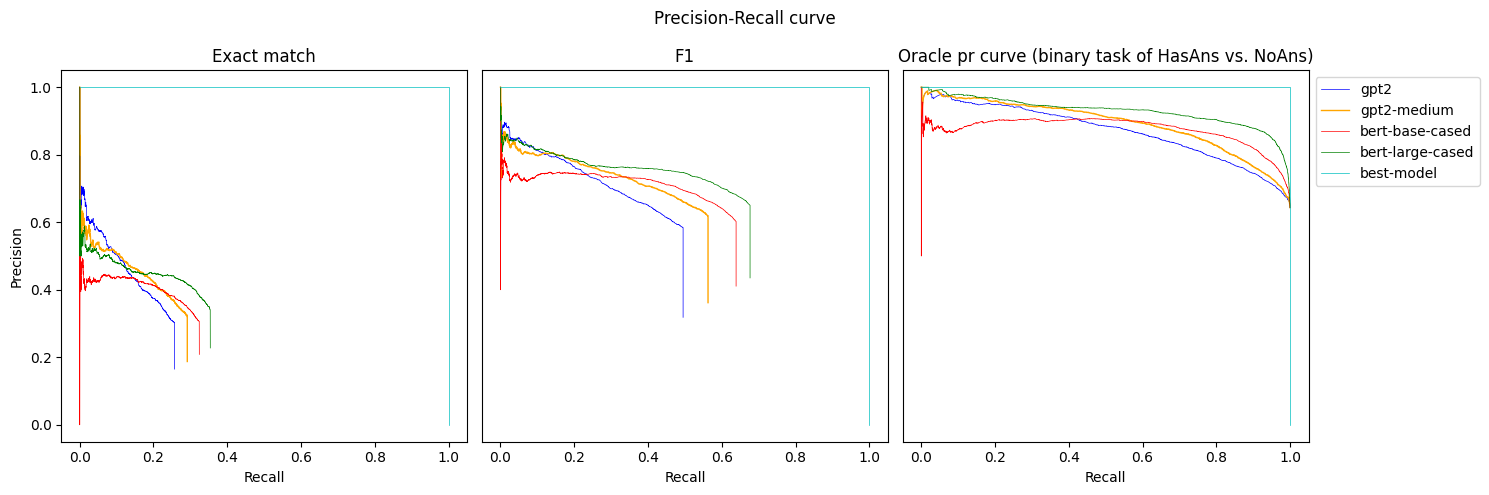

In [ ]:
def plot_pr_curve(i, mc, c, precisions, recalls, title):
  ax[i].plot(recalls, precisions, color=c, linewidth=1 if c == 'orange' else 0.5, label=mc)
  ax[i].set_xlabel("Recall")
  ax[i].set_title(title)
  if i > 0:
    ax[i].tick_params(axis='y', which='both', length=0)
  if i == 0:
    ax[i].set_ylabel("Precision")
  if i == 2:
    ax[i].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)

model_cards = ['gpt2', 'gpt2-medium', 'bert-base-cased', 'bert-large-cased']
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15, 5))

for mc in model_cards:
  with open(os.path.join(f'result_{mc}', 'result.json'), 'r') as f:
    model_result = json.load(f)

  refs, preds = find_ref_pred(model_result)
  pr_exact, pr_f1, o_pr_scores = find_prc(refs, preds)

  if mc == 'gpt2': c = 'b'
  elif mc == 'gpt2-medium': c = 'orange'
  elif mc == 'bert-base-cased': c = 'red'
  elif mc == 'bert-large-cased': c = 'green'

  plot_pr_curve(0, mc, c, pr_exact[0], pr_exact[1], 'Exact match')
  plot_pr_curve(1, mc, c, pr_f1[0], pr_f1[1], 'F1')
  plot_pr_curve(2, mc, c, o_pr_scores[0], o_pr_scores[1], 'Oracle pr curve (binary task of HasAns vs. NoAns)')

mc = 'best-model'
plot_pr_curve(0, mc, 'c', [1, 1, 0], [0, 1, 1], 'Exact match')
plot_pr_curve(1, mc, 'c', [1, 1, 0], [0, 1, 1], 'F1')
plot_pr_curve(2, mc, 'c', [1, 1, 0], [0, 1, 1], 'Oracle pr curve (binary task of HasAns vs. NoAns)')

plt.suptitle('Precision-Recall curve')
plt.tight_layout()
plt.savefig('prcurve.png')
plt.show()